## Visualization for Grad-CAM

This is a script to show how to use Grad-CAM for models in this repo. The script is modified from the official document of [Grad-CAM](https://jacobgil.github.io/pytorch-gradcam-book/Class%20Activation%20Maps%20for%20Object%20Detection%20With%20Faster%20RCNN.html)

本脚本用于展示如何用Grad-CAM包为本仓库的模型进行可视化。脚本参考调整自[Grad-CAM](https://jacobgil.github.io/pytorch-gradcam-book/Class%20Activation%20Maps%20for%20Object%20Detection%20With%20Faster%20RCNN.html)的官方文档

### Preliminary 

load model, image and get inference results, similar to [inference.ipynb](inference.ipynb)

首先准备模型、图片，获取推理结果，这部分类似[inference.ipynb](inference.ipynb)

In [1]:
# import the necessary packages
import os
import sys

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt

os.chdir(os.path.dirname(os.path.abspath(".")))
sys.path.insert(0, os.path.dirname(os.path.abspath(".")))

from configs.salience_detr.salience_detr_resnet50_800_1333 import model
from util.utils import load_state_dict
from util.visualize import plot_bounding_boxes_on_image_cv2

c:\Users\WE\miniconda3\envs\salience_detr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\WE\Desktop\Salience-DETR\models\bricks\ms_deform_attn.py:26: UserWarning: No cuda is available, skip loading MultiScaleDeformableAttention C++ extention
  warnings.warn("No cuda is available, skip loading MultiScaleDeformableAttention C++ extention")
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
# load model state dict and set to eval mode
weight = torch.load("salience_detr_resnet50_800_1333_coco_2x.pth", map_location="cpu")
load_state_dict(model, weight)
model = model.eval()

INFO:Salience-DETR.util.utils:<All keys matched successfully>


In [3]:
# prepare input image
image_name = "data/coco/val2017/000000000139.jpg"
save_name = image_name.replace(".jpg", ".pth")
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_tensor = torch.tensor(image).permute(2, 0, 1)

In [4]:
# get predictions from the model
input_tensor = image_tensor.unsqueeze(0)  # add a batch dimension
predictions = model(input_tensor)

# post process, cut-gradient and process data type
labels = predictions[0]['labels'].cpu().numpy()
scores = predictions[0]['scores'].detach().cpu().numpy()
boxes = predictions[0]['boxes'].detach().cpu().numpy()

# filter out low confidence predictions
detection_threshold = 0.8
valid_index = scores >= detection_threshold
labels = labels[valid_index]
scores = scores[valid_index]
boxes = boxes[valid_index]
boxes = np.int32(boxes)

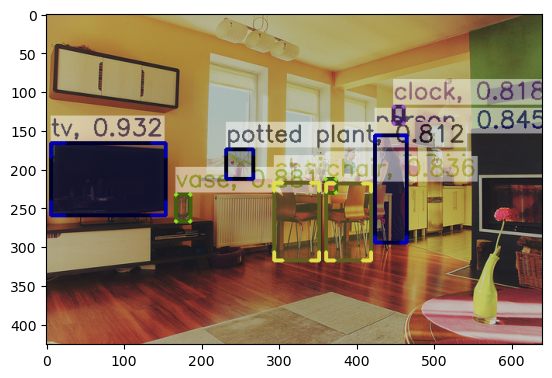

In [5]:
# show inference results
image_for_show = plot_bounding_boxes_on_image_cv2(image, boxes, labels, scores, model.CLASSES)
plt.imshow(image_for_show)

Grad-CAM is incompatible with low-version pytorch, so we re-implement those code.

Grad-CAM某些代码不兼容低版本pytorch，因此我们修改了不兼容的部分。

In [6]:
import torch.backends
import torchvision


class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()
        elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            output = output.to("mps")

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()
            elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
                box = box.to("mps")

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

### Grad-CAM visualization

Typically Grad-CAM is used to visualize the multi-scale feature maps from the backbone of a model. We can plot Grad-CAM for the single feature map or the average of all feature maps. Please modify the `feature_map_indice` accordingly.

一般Grad-CAM会用来可视化模型backbone输入的多尺度特征图，可以用来可视化单层特征图或所有特征图的平均值。请相应地调整`feature_map_indice`参数。

In [7]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

feature_map_indice = "mean"  # choose from: 0, 1, 2, 3, "mean"

In [8]:
def fasterrcnn_reshape_transform(x):
    target_size = list(x.values())[-1].size()[-2:]

    # Show Grad-CAM for aggregated feature maps
    if feature_map_indice == "mean":
        activations = []
        for key, value in x.items():
            activations.append(
                torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear')
            )
        activations = torch.cat(activations, axis=1)
        return activations

    # Show Grad-CAM for single feature map
    assert feature_map_indice in [0, 1, 2, 3]
    return list(x.values())[feature_map_indice]  # 0, 1, 2, 3

image_float_np = np.float32(image) / 255
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

### EigenCAM

In [9]:
# get grad_cam
cam = EigenCAM(model, target_layers, reshape_transform=fasterrcnn_reshape_transform)


grayscale_cam = cam(input_tensor, targets=targets)[0, :]  # take the first image in the batch
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

# plot bounding_boxes and labels
image_with_bounding_boxes = plot_bounding_boxes_on_image_cv2(cam_image, boxes, labels, classes=model.CLASSES)

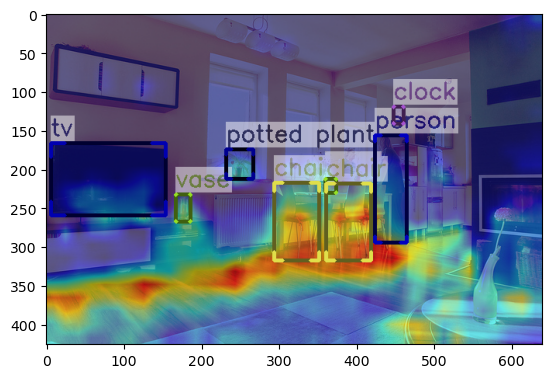

In [10]:
from matplotlib import pyplot as plt
# plt.imshow(cam_image)  # cam without bounding boxes
plt.imshow(image_with_bounding_boxes)